<a href="https://colab.research.google.com/github/arpanbiswas52/MOBO_PhysicsBasedModels/blob/main/SimpleGP_BO_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Simple GP/BO tutorial 

-- Aug 24, 2021

prepared by **Arpan Biswas**

This notebooks provides the codes of Simple GP/BO exploration. This is part 1 of the notebook

Here we illustrate,

-- 1D Gaussian Process and search space exploration by maximizing acquisition function (using BO).


Install Packages

In [ ]:
!pip install botorch #version 0.5.0
!pip install gpytorch #version 1.5.0

     |████████████████████████████████| 475 kB 8.5 MB/s 
     |████████████████████████████████| 498 kB 37.7 MB/s 


Import functions

In [ ]:
#Import classical numpy and torch
import torch as to
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Random # generator
import random

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from botorch import fit_gpytorch_model
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP


#Import optimizer algorithm to train GP hyperparameters
from torch.optim import SGD
from torch.optim import Adam

#other math functions
from scipy.stats import norm






Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Acquistion functions- Expected Improvment (EI) and Probability of Improvement (PI)
3. Optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
4. Plot function for BO exploration and acquistion function

In [ ]:
#########################Gaussian Process########################
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        ## Here we use constant mean, user can change here with different mean function
        self.mean_module = ConstantMean()
        ## Here we use Radial Basis function kernel, user can change here with different kernel function
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

############## Optimize Hyperparameters of GP##############################
def optimize_hyperparam_trainGP(train_X, train_Y):
    # Gp model fit
    gp_surro = SimpleCustomGP(train_X, train_Y)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll = ExactMarginalLogLikelihood(gp_surro.likelihood, gp_surro)
    # fit_gpytorch_model(mll)
    mll = mll.to(train_X)
    gp_surro.train()
    gp_surro.likelihood.train()
    ## Here we use Adam optimizer with learning rate =0.2, user can change here with different algorithm and/or learning rate
    optimizer = Adam([{'params': gp_surro.parameters()}], lr=0.2)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output = gp_surro(train_X)
        # Compute negative marginal log likelihood
        loss = - mll(output, gp_surro.train_targets)
        # back prop gradients
        loss.backward()
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS:
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss:" + str(loss.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise:" + str(gp_surro.likelihood.noise.item()))

        optimizer.step()

    gp_surro.eval()
    gp_surro.likelihood.eval()
    return gp_surro

########## BO acquisition function ###########################
def acqmanEI(y_pred_means, y_pred_vars, train_Y):


    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    EI_val = np.zeros(len(y_pred_vars))
    Z = np.zeros(len(y_pred_vars))
    eta = 0.001
    for i in range(0, len(y_pred_vars)):
        if (y_pred_vars[i] <=0):
            EI_val[i] = 0
        else:
            Z[i] =  (y_pred_means[i]-best_value-eta)/y_pred_vars[i]
            EI_val[i] = (y_pred_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_pred_vars[i]*norm.pdf(Z[i])

    acq_val = np.max(EI_val)
    acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
    return acq_cand, acq_val, EI_val

def acqmanPI(y_pred_means, y_pred_vars, train_Y):


    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    PI_val = np.zeros(len(y_pred_vars))
    Z = np.zeros(len(y_pred_vars))
    eta = 0.001
    for i in range(0, len(y_pred_vars)):
        if (y_pred_vars[i] <=0):
            PI_val[i] = 0
        else:
            Z[i] =  (y_pred_means[i]-best_value-eta)/y_pred_vars[i]
            PI_val[i] = norm.cdf(Z[i])

    acq_val = np.max(PI_val)
    acq_cand = [k for k, j in enumerate(PI_val) if j == acq_val]
    return acq_cand, acq_val, PI_val



##########Plotting functions#########################################
def plot_exploration_results(X, true_y, y_pred_means, y_pred_vars, train_X, train_Y, acq_val, maxacq_val, i):
    y_pred_sd = np.sqrt(y_pred_vars)
    Y_pred_upper = y_pred_means+(2*y_pred_sd)
    Y_pred_lower = y_pred_means-(2*y_pred_sd)
    old_X = train_X[:-1].detach().numpy()
    old_Y = train_Y[:-1].detach().numpy()
    new_X = train_X[-1].detach().numpy()
    new_Y = train_Y[-1].detach().numpy()
    _, ax = plt.subplots(2, 1, figsize=(5, 10))
    #Plotting for BO exploration in GP predicted function
    ax[0].plot(X,true_y, c='gray', linestyle = '--', linewidth=2)
    ax[0].plot(X, y_pred_means.detach().numpy(), c='blue', linewidth=2)
    ax[0].plot(X, Y_pred_upper.detach().numpy(), c='black', linewidth=2)
    ax[0].plot(X, Y_pred_lower.detach().numpy(), c='black', linewidth=2)
    ax[0].scatter(old_X, old_Y, c='green', marker='o')
    ax[0].scatter(new_X, new_Y, c='red', marker='X')
    #ax[0].legend(loc="best")
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Z')
    ax[0].set_title("iter=" + str(i))
    #Plotting for BO exploration in acquistion function
    ax[1].plot(X, acq_val, c='blue', linewidth=2)
    ax[1].scatter(new_X, maxacq_val, c='red', marker='X')
    #ax[1].legend(loc="best")
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('acq. func. value')
    #plt.savefig(str(i-1) + '.png')
    #ax[1].set_title("iter=" + str(iter))
    plt.show()





Objective function considered for BO exploration

In [ ]:
def func1D(x):
    f= np.sin(x)**3 + np.sin(x**2)
    return f

<h1> Conceptual diagram for BO exploration- 1D search space, single objective

**Running BO with Acquistion function - EI**

Here, we select 1000 grid values of $X=[-\pi, \pi]$.

Start with 5 random initial locations.

Stopped after 50 BO iterations

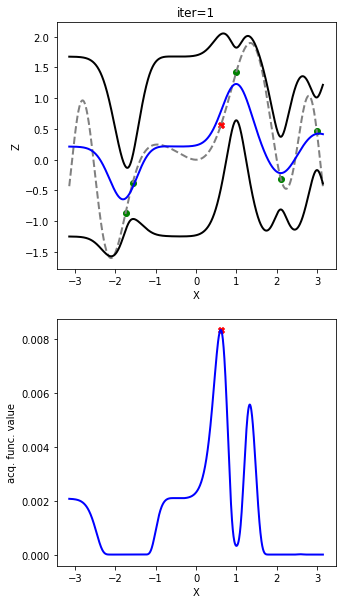

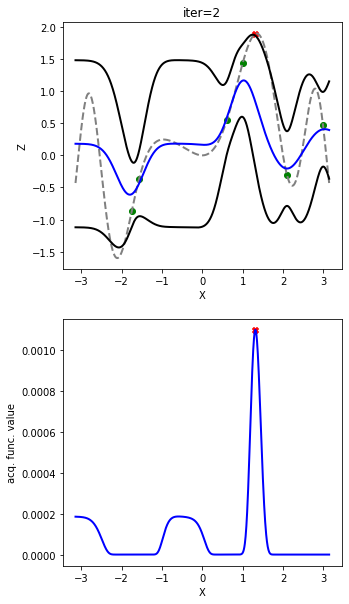

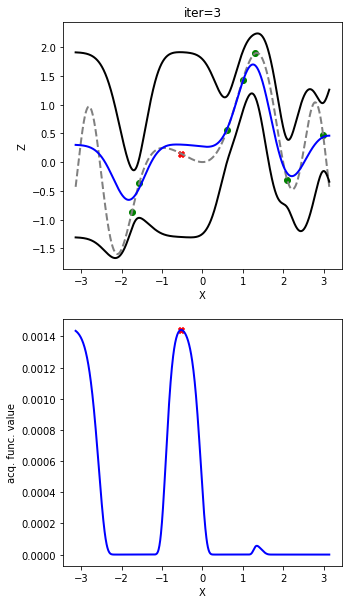

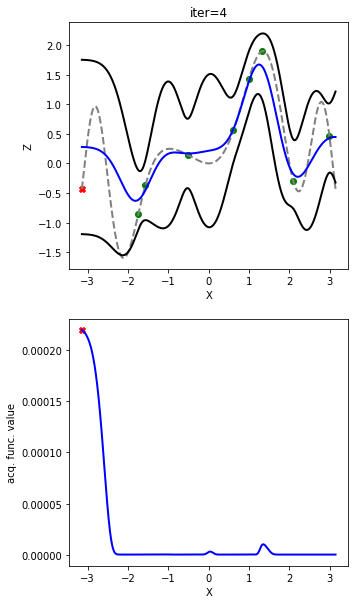

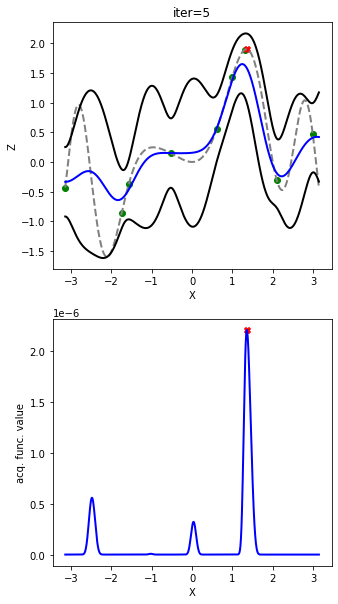

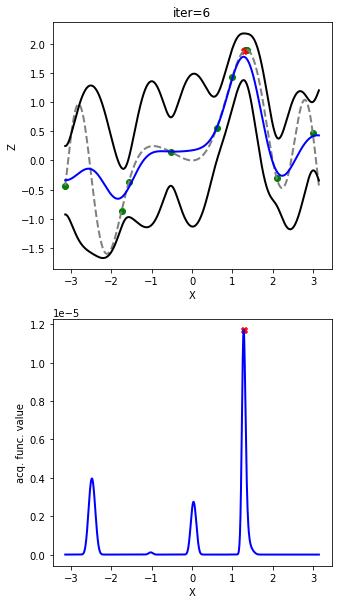

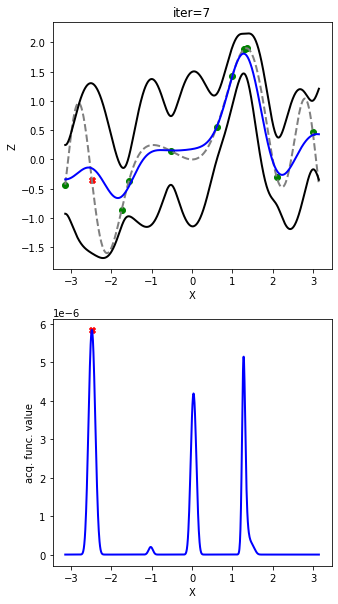

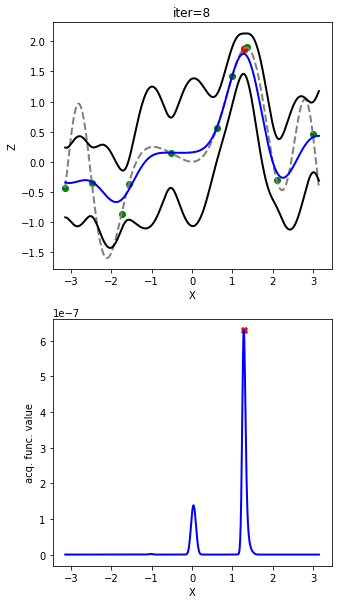

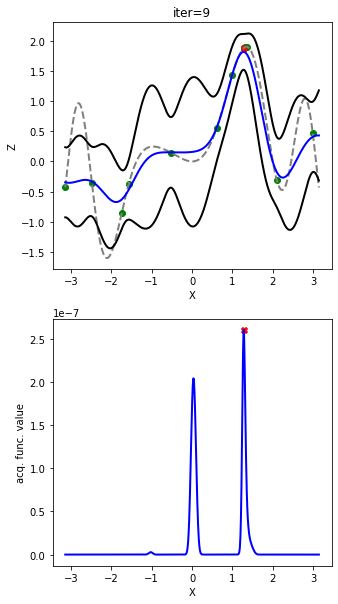

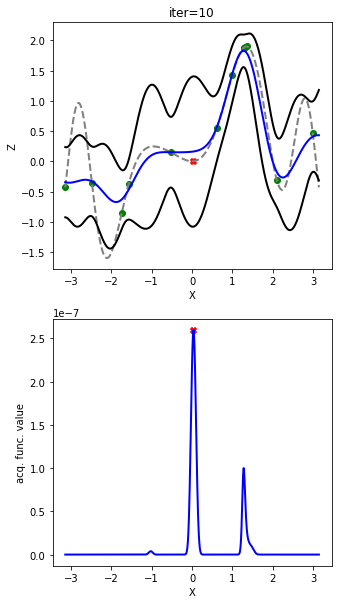

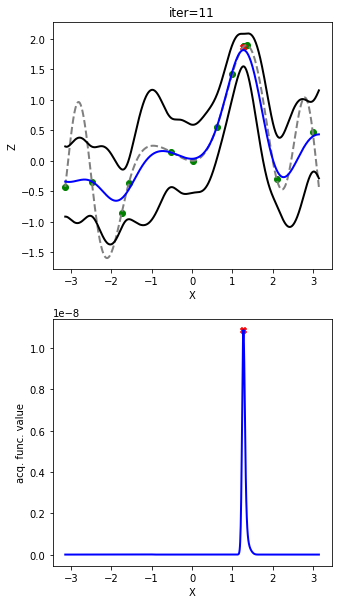

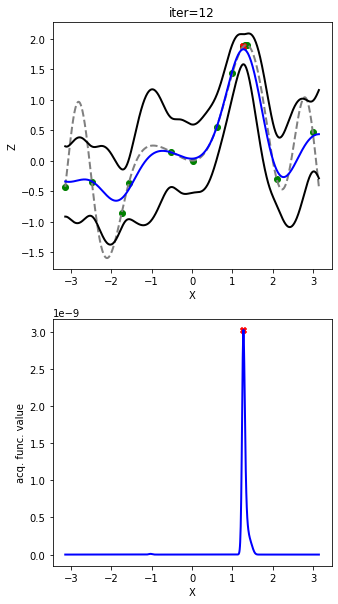

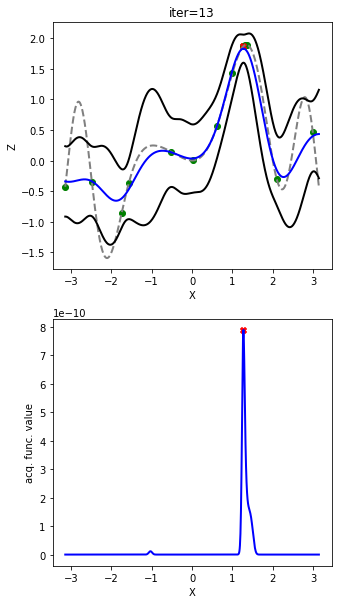

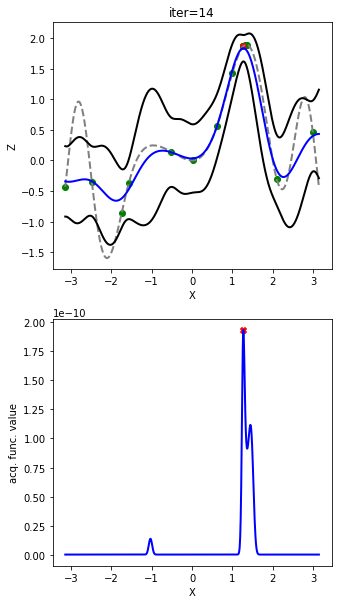

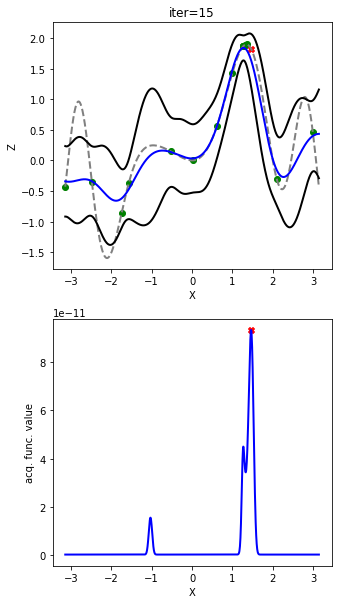

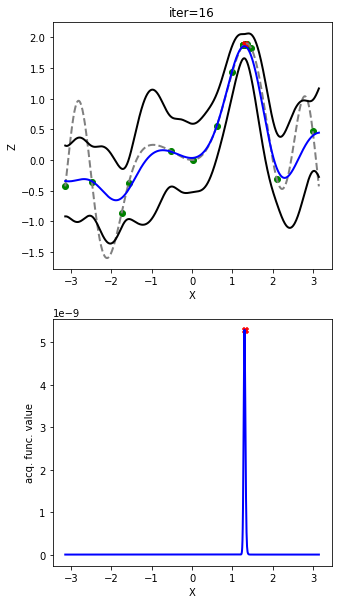

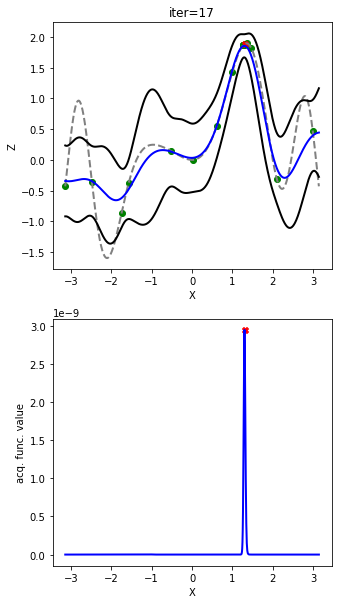

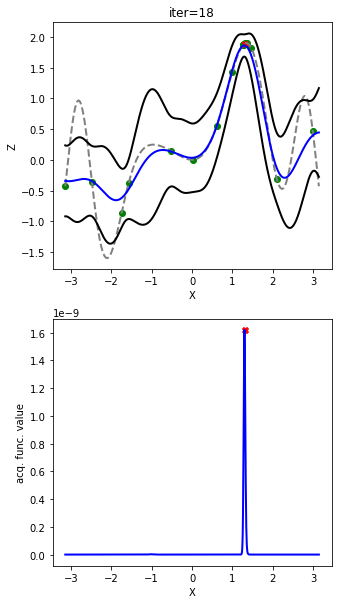

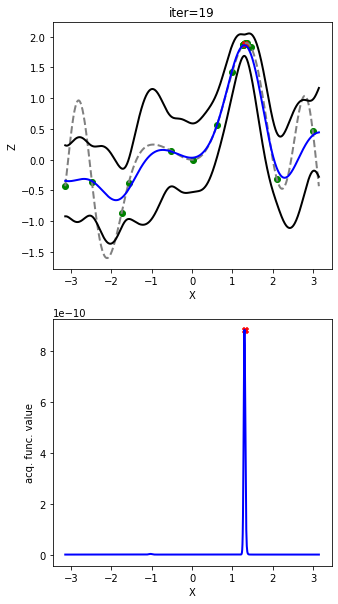

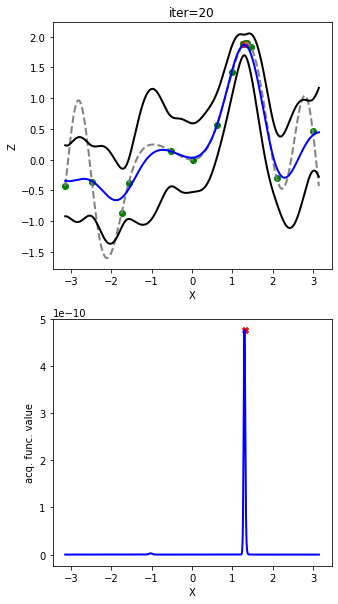

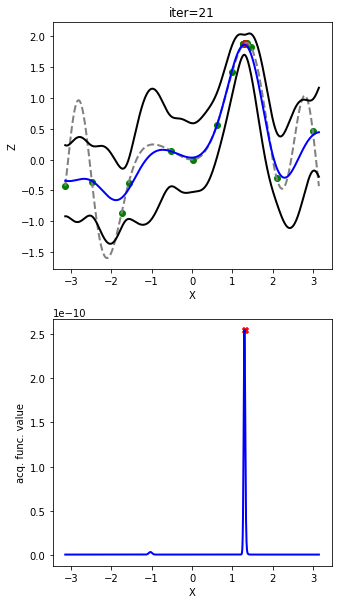

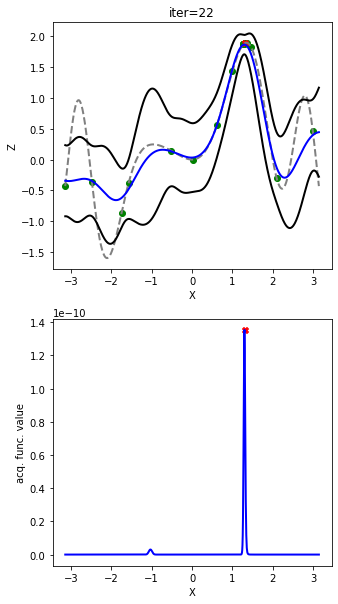

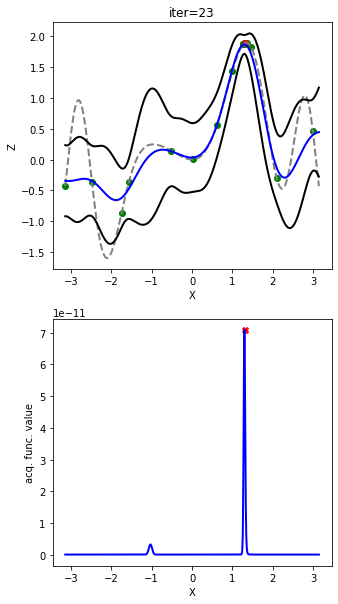

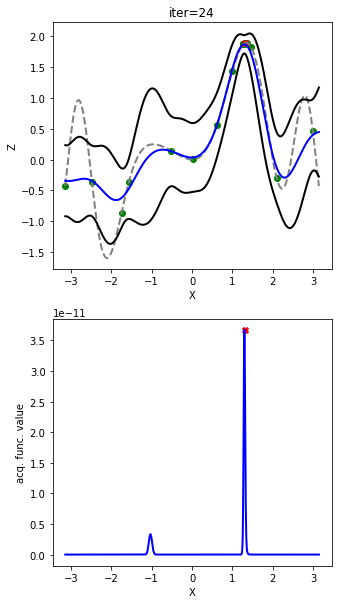

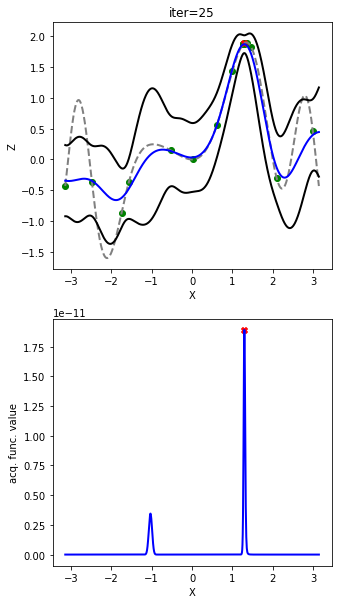

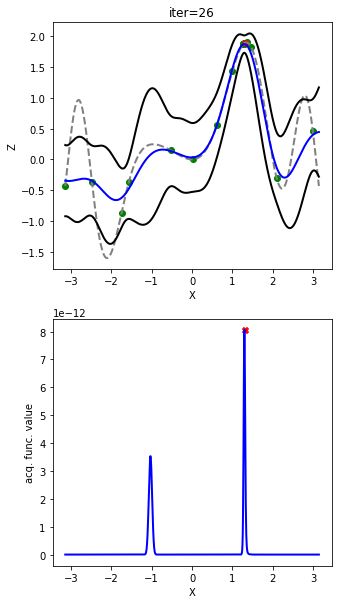

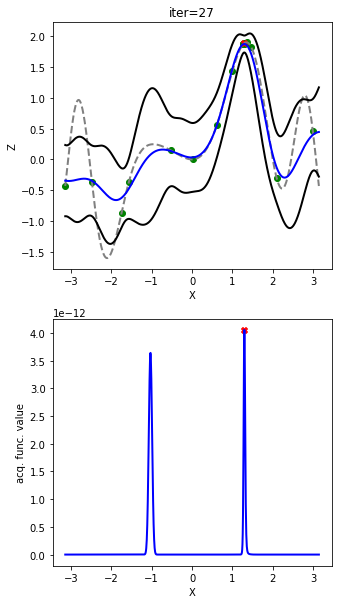

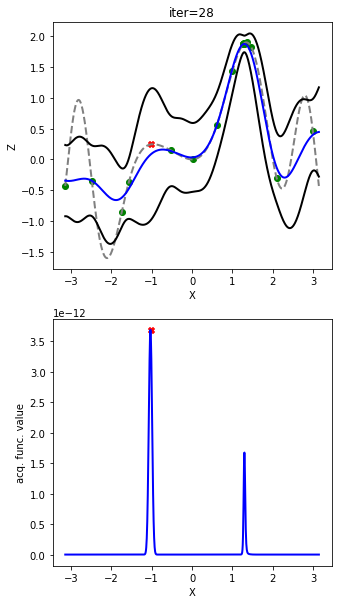

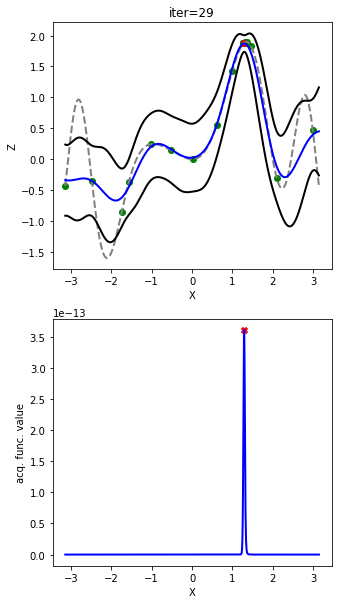

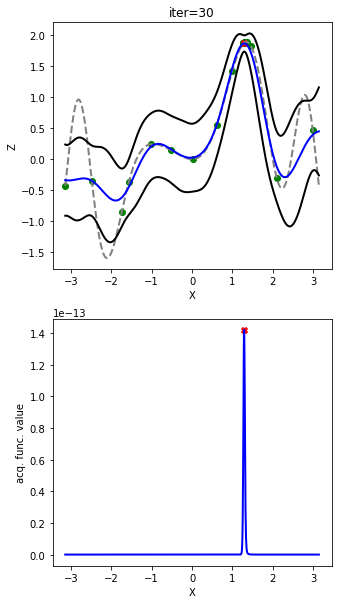

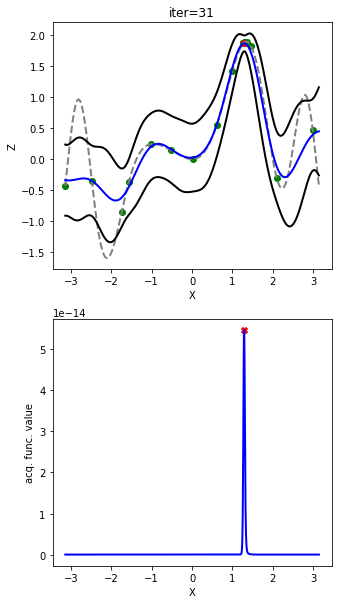

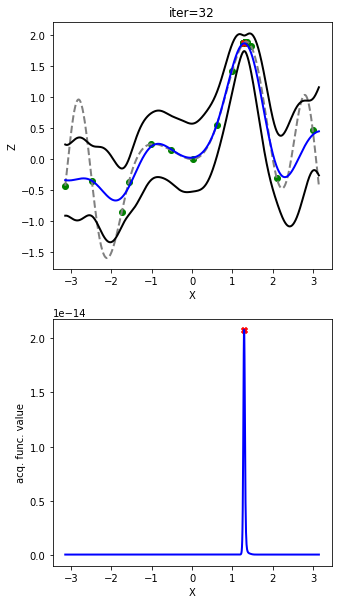

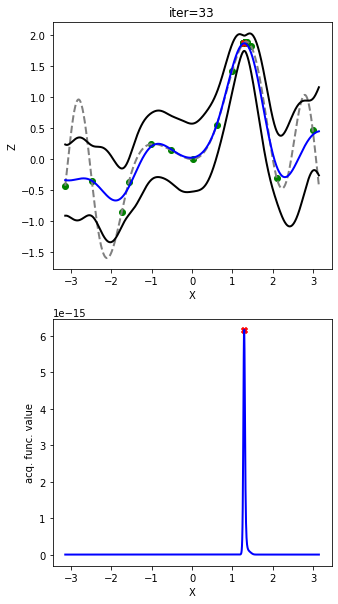

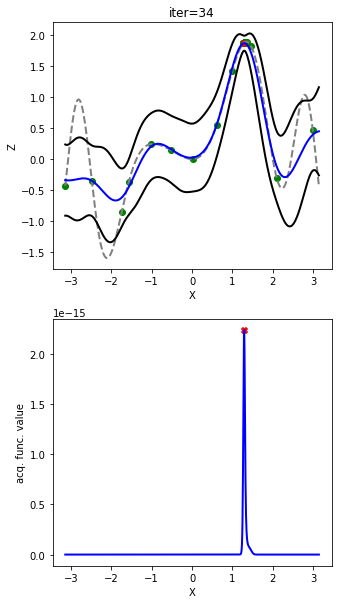

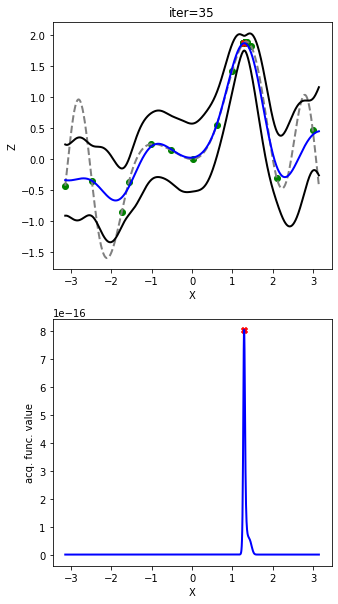

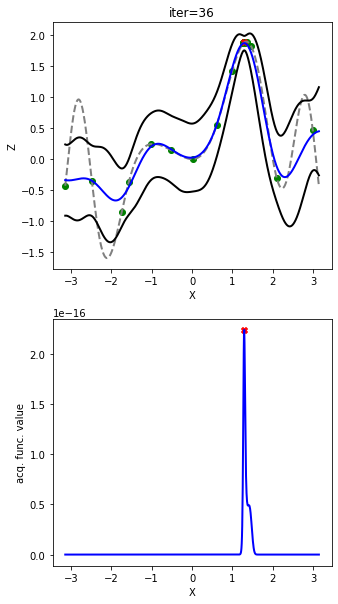

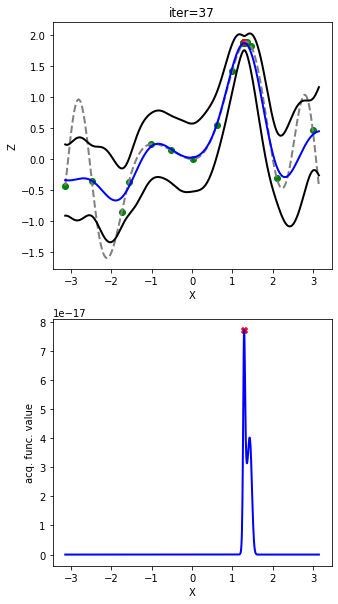

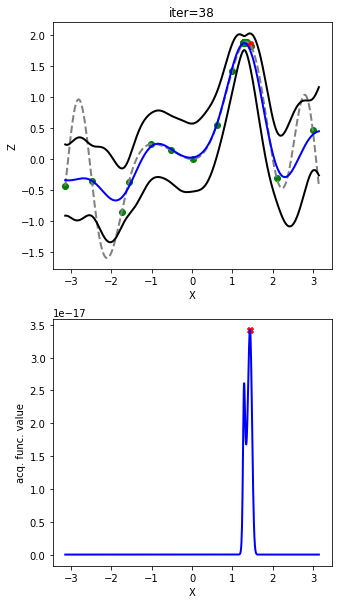

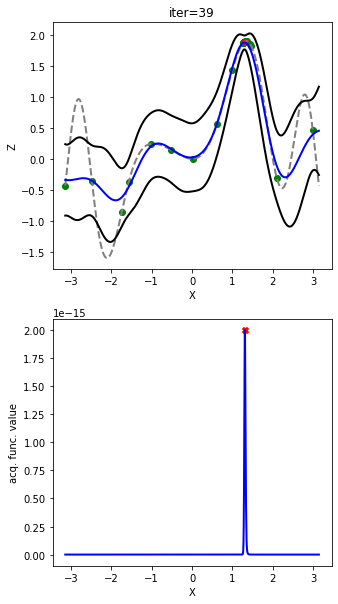

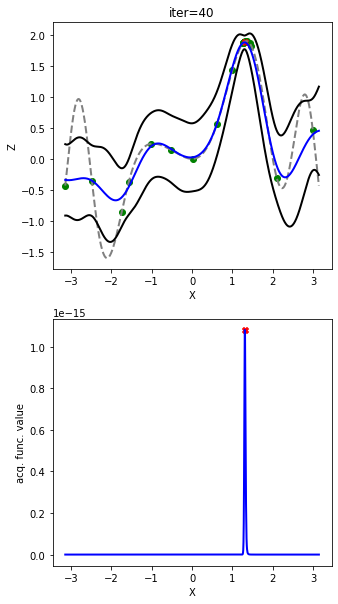

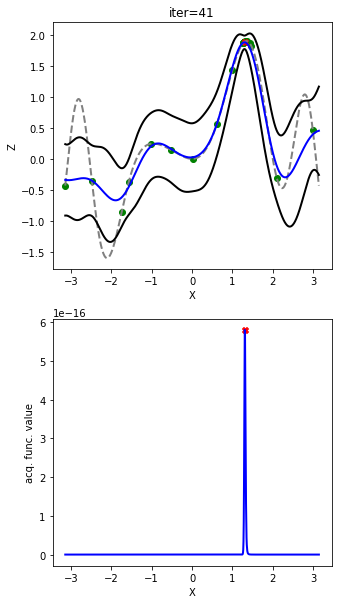

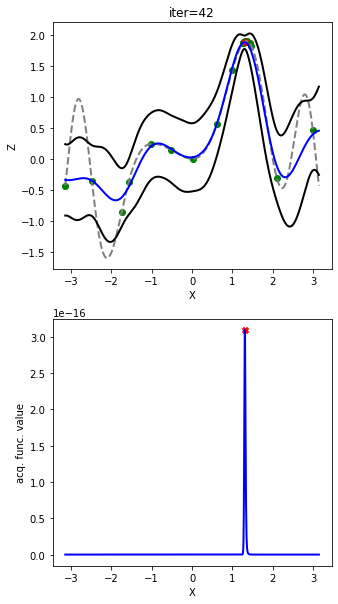

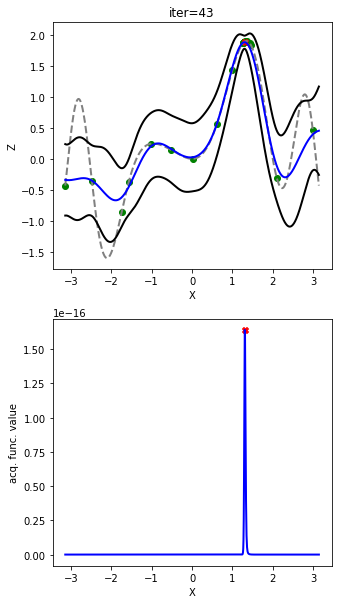

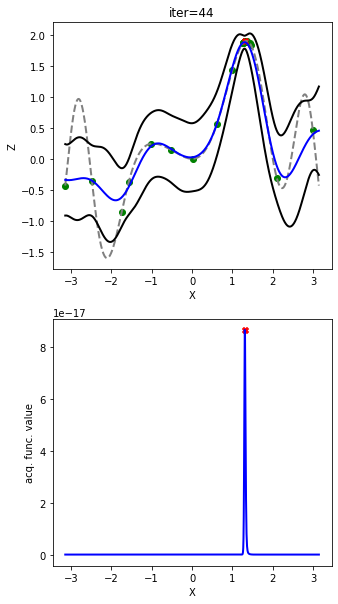

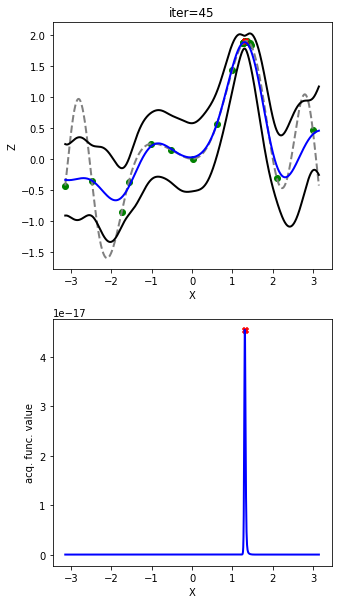

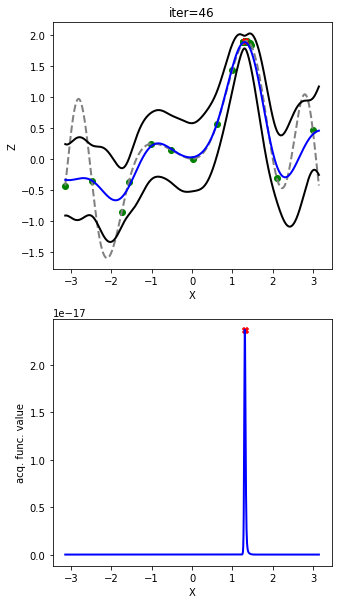

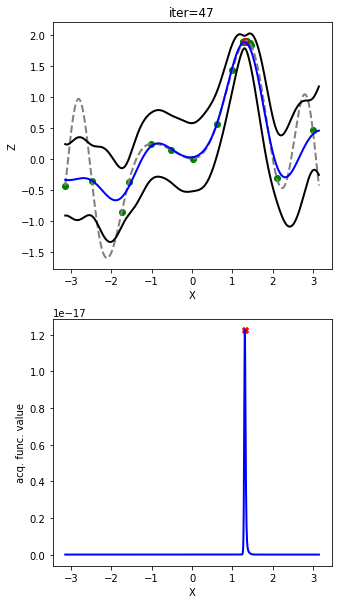

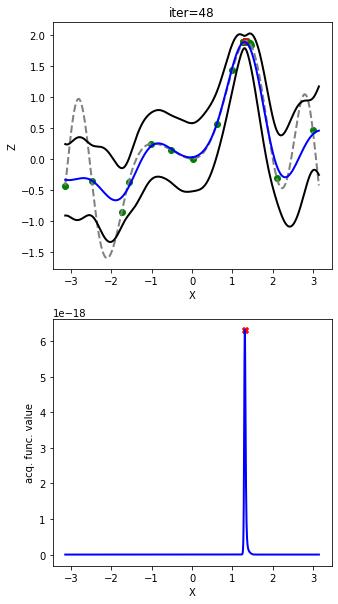

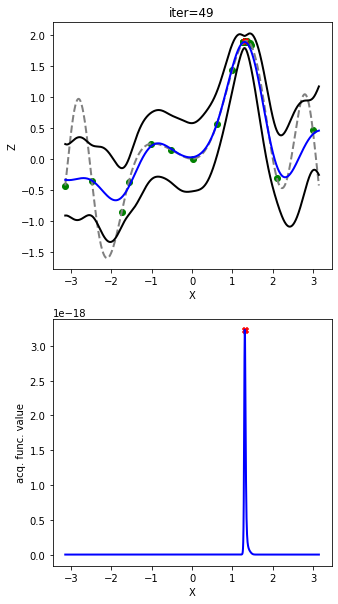

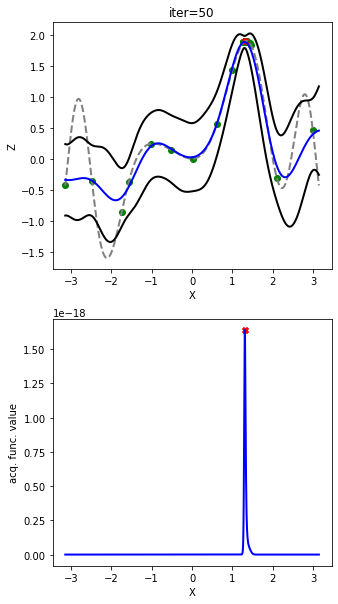

Max. sampling reached, model stopped


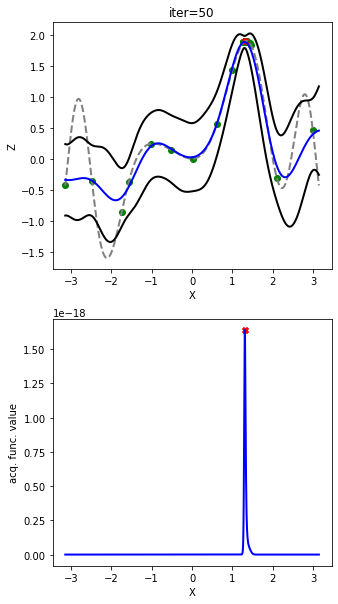

In [ ]:
############# Analysis#####################
num_rows=1000
num=5
N=50
X = np.linspace(-np.pi, np.pi, num_rows)
np.random.seed(10)
ind_start = np.random.choice(len(X) - 1, size=num, replace=False)
train_x = np.zeros(num)
train_y = np.zeros(num)
true_y = np.zeros(num_rows)
for i in range(0, num):
    train_x[i] = X[ind_start[i]]
    train_y[i] = func1D(train_x[i])

for i in range(0, num_rows):
    true_y[i] = func1D(X[i])
#Convert to torch
train_x = to.from_numpy(train_x)
train_X = to.empty(train_x.__len__(), 1)
train_X[:, 0] = train_x
train_X = train_X.double()
train_y = to.from_numpy(train_y)
train_Y = to.empty(train_y.__len__(), 1)
train_Y[:, 0] = train_y

## Gp model fit
#Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
# Input args- Torch arrays of training data, parameter X and objective eval Y
# Output args- Gaussian process model
gp_surro= optimize_hyperparam_trainGP(train_X, train_Y)


for i in range(1, N + 1):
    y_pred_means = to.empty(num_rows)
    y_pred_vars = to.empty(num_rows)
    for j in range(0, num_rows):
        test_X = to.empty(1,1)
        test_X[:, 0] = X[j]
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
             #Calculate posterior means and variances
            y_pred_surro = gp_surro.posterior(test_X)
            y_pred_means[j] = y_pred_surro.mean
            y_pred_vars[j] = y_pred_surro.variance

    ###Calling function to compute acquistion function value. Here user can select either EI-- acqmanEI() or PI--acqmanPI()
    # Input args- Torch arrays of GP posterior means, variances and current training objective eval Y
    # Output args- location cadidate for maximum acq. value, maximum acq.val. and acq. value for all candidate locations
    acq_cand, maxacq_val, acq_val = acqmanEI(y_pred_means, y_pred_vars, train_Y)
    val = maxacq_val
    ind = np.random.choice(acq_cand)
    if ((val) == 0):  # Stop for negligible expected improvement
        print("Model converged due to sufficient learning over search space ")
        break
    else:
        #Augment new data with current (training) data
        nextX = to.empty(1, 1)
        next_feval = to.empty(1, 1)
        nextX[0, 0] = X[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        next_feval[:, 0] = func1D(X[ind])
        train_Y = to.cat((train_Y, next_feval), 0)
        #plotting function
        plot_exploration_results(X, true_y, y_pred_means, y_pred_vars, train_X, train_Y, acq_val, maxacq_val, i)

        # Gp model fit
        #Updating GP with augmented training data
        #Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
        # Input args- Torch arrays of training data, parameter X and objective eval Y
        # Output args- Gaussian process model
        gp_surro = optimize_hyperparam_trainGP(train_X, train_Y)


## Final posterior prediction after all the sampling done

if (i == N):
    print("Max. sampling reached, model stopped")
    #plotting function
    plot_exploration_results(X, true_y, y_pred_means, y_pred_vars, train_X, train_Y, acq_val, maxacq_val, i)

**Running BO with Acquistion function - PI**

Here, we select 1000 values of $X=[-\pi, \pi]$.

Start with 5 random initial locations.

Stopped after 50 BO iterations

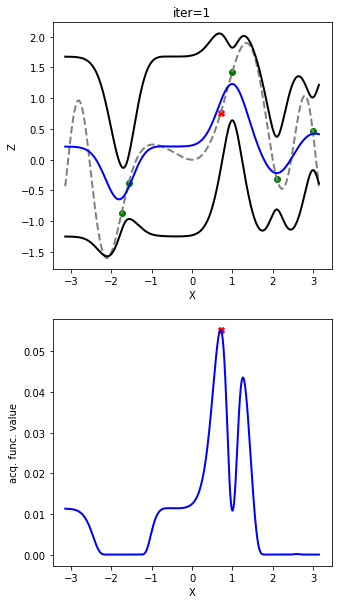

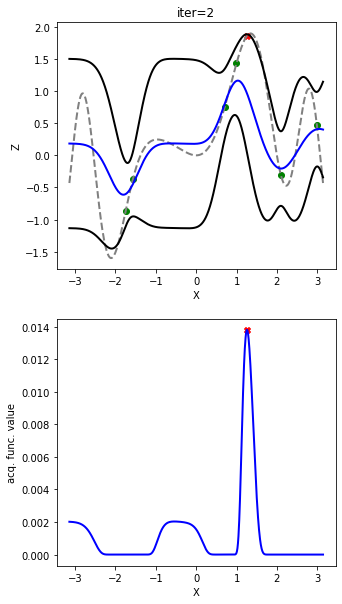

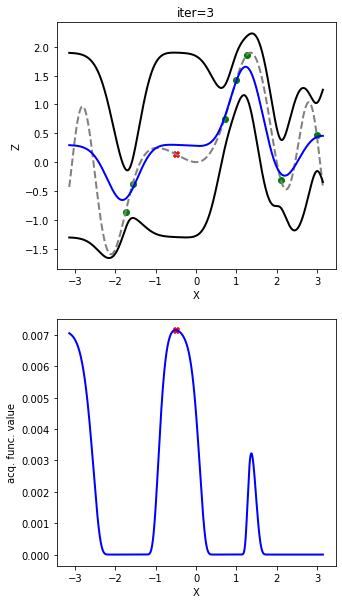

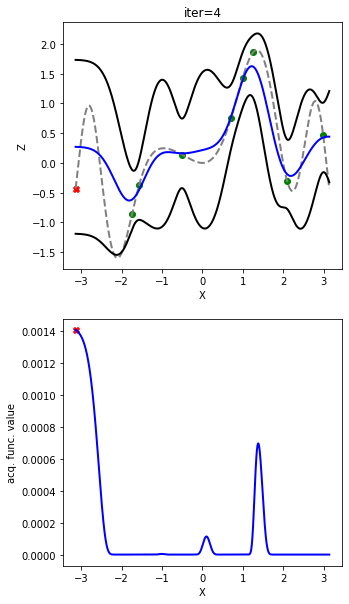

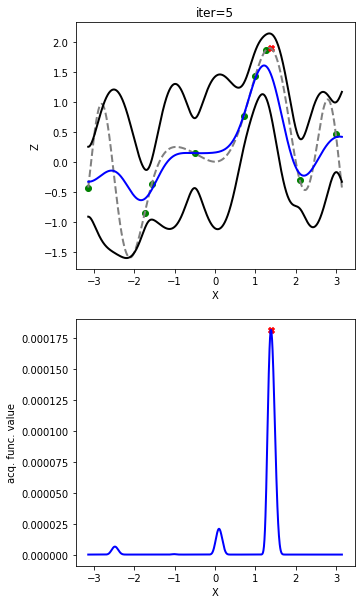

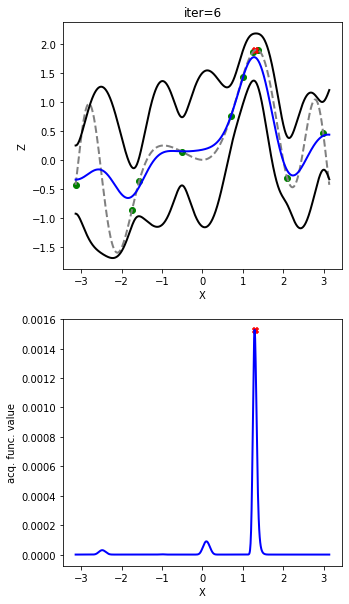

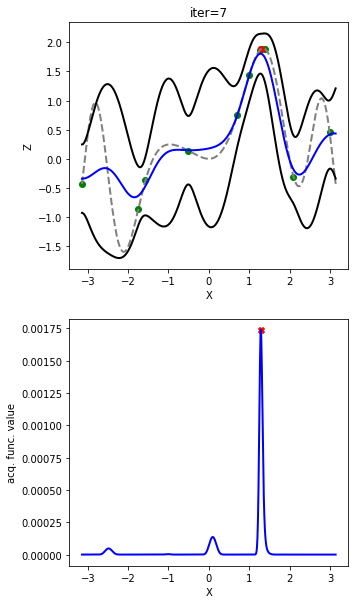

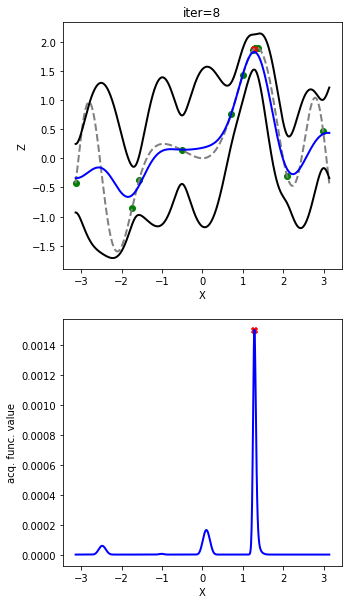

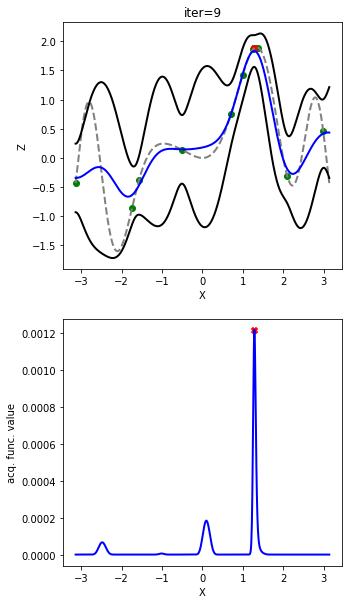

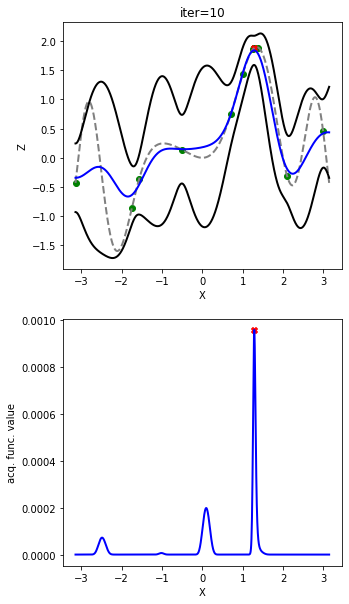

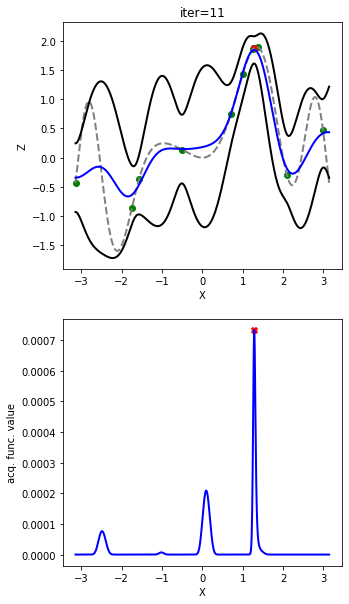

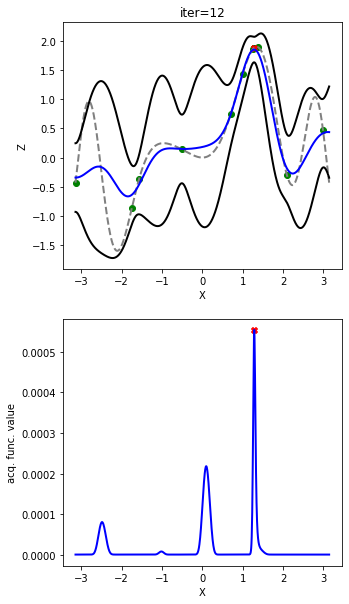

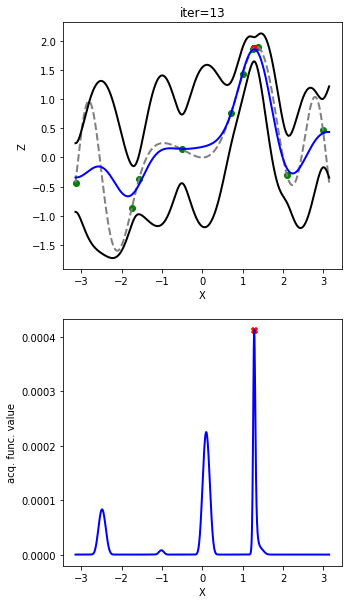

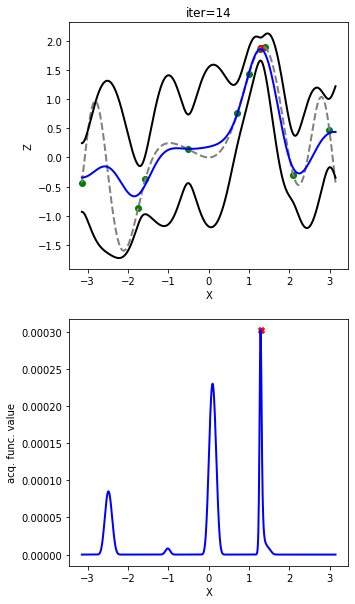

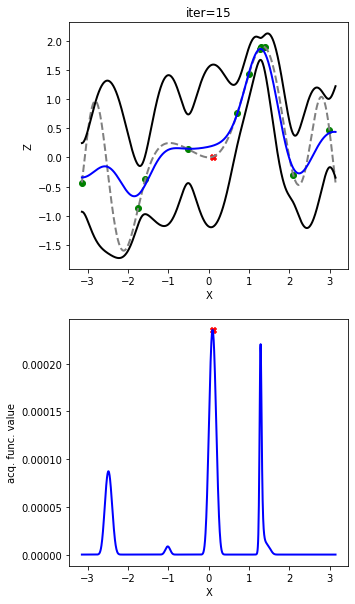

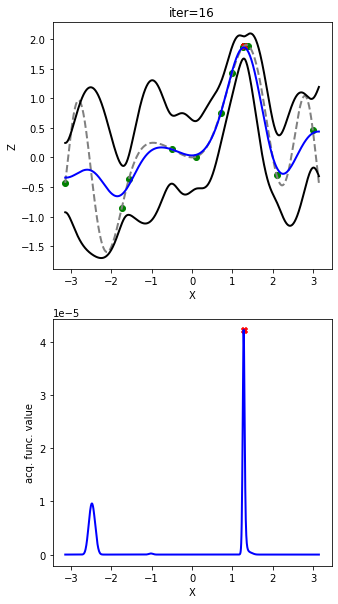

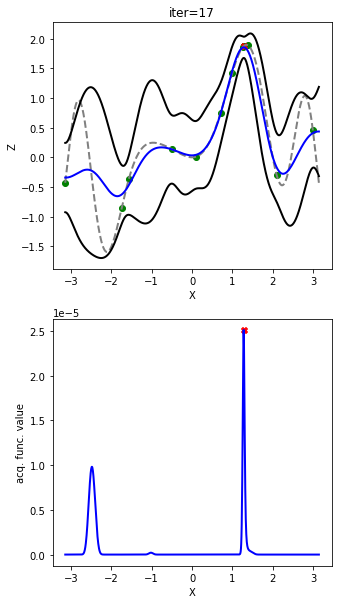

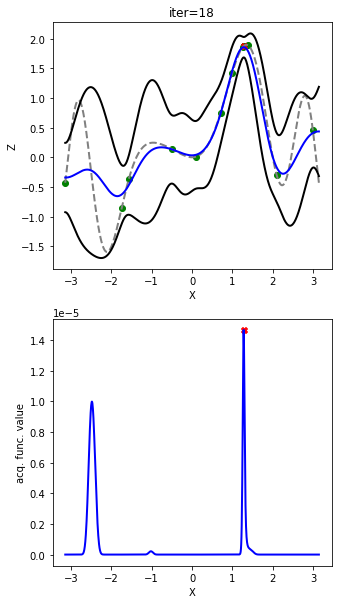

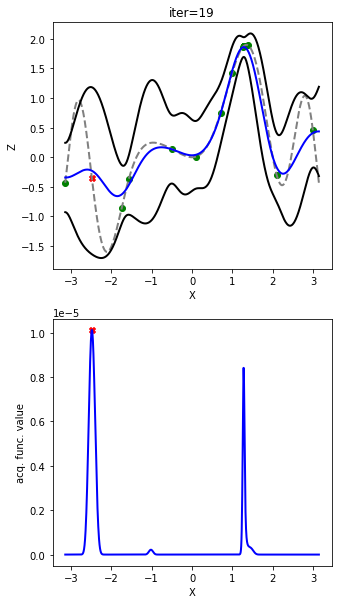

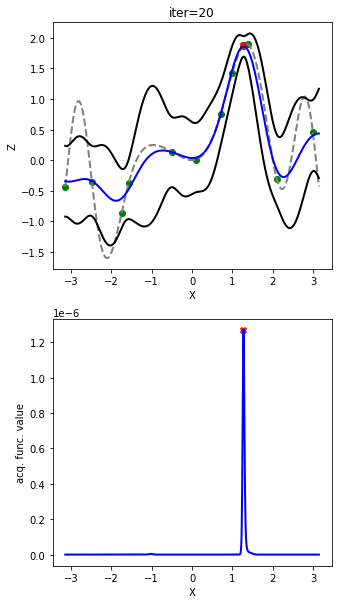

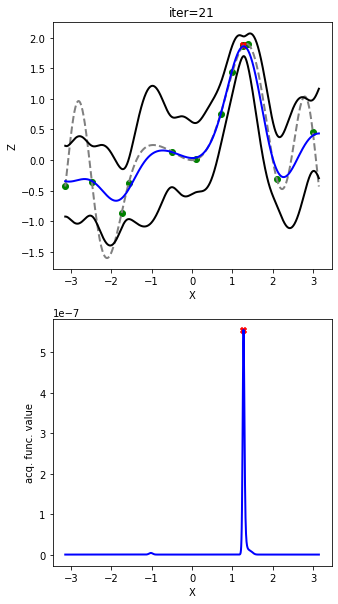

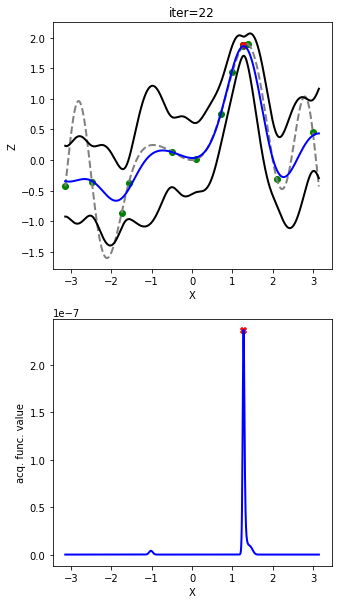

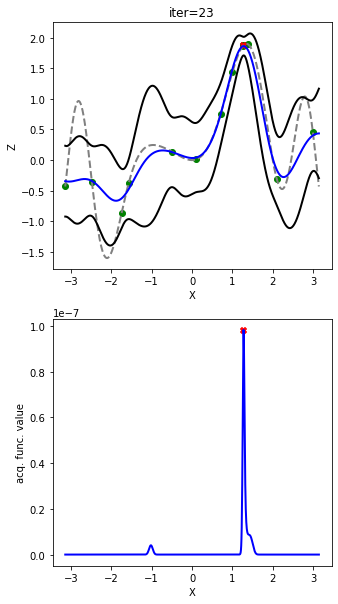

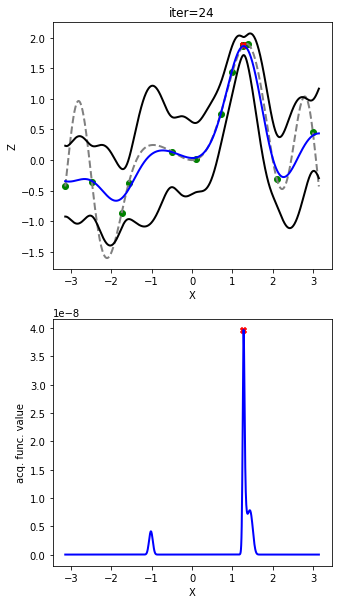

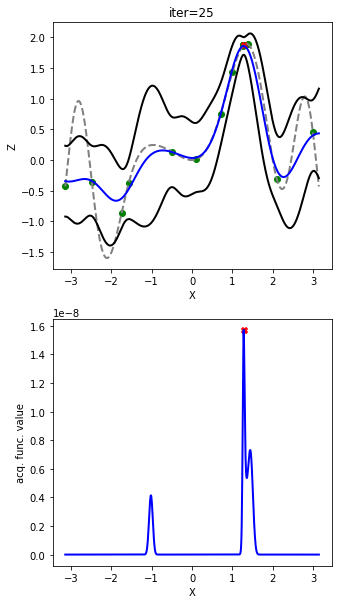

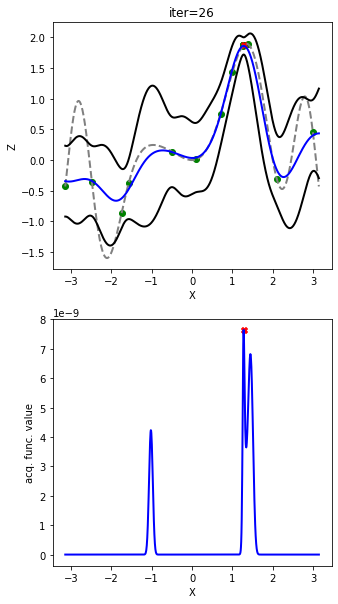

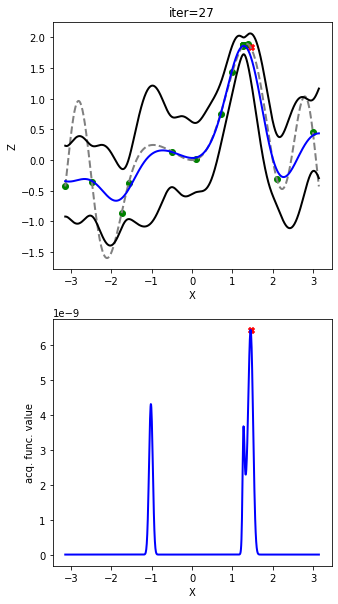

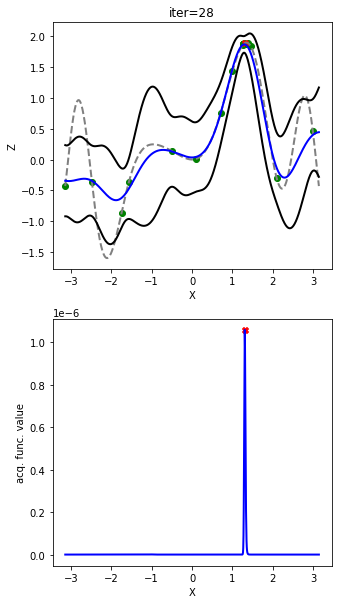

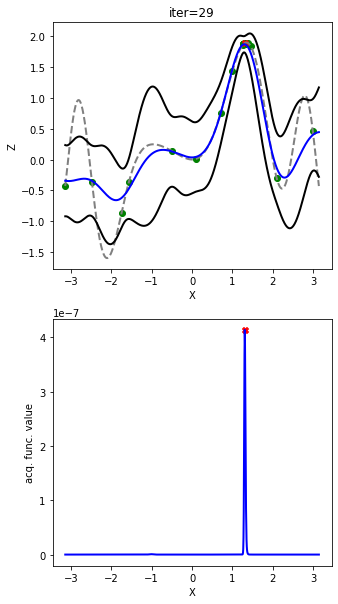

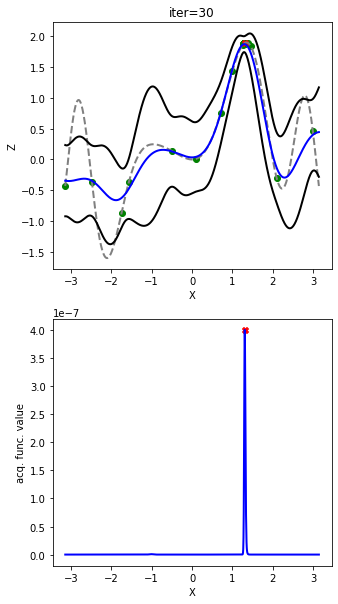

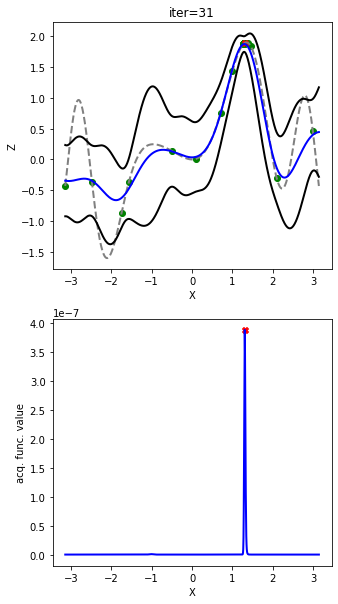

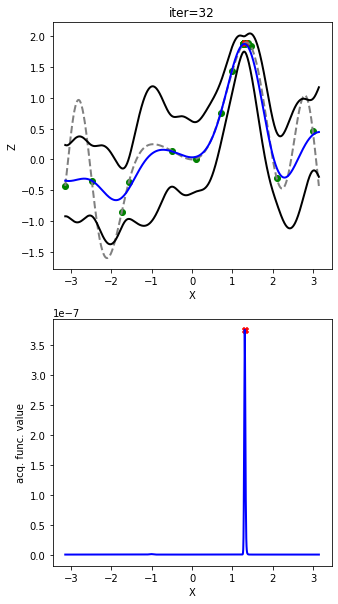

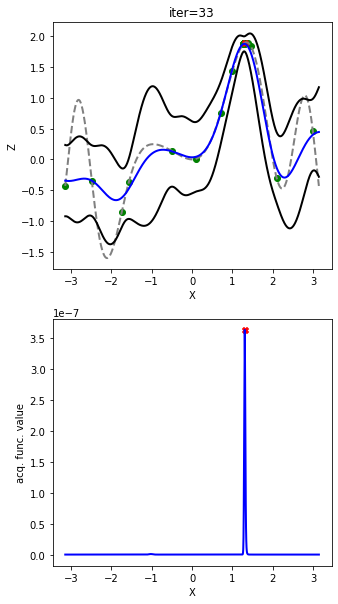

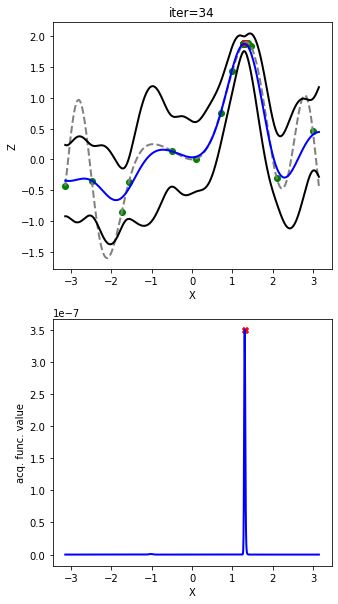

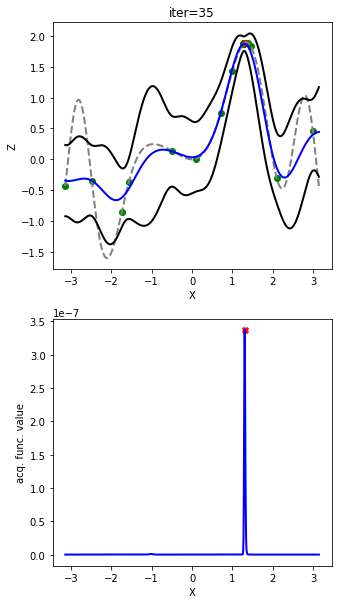

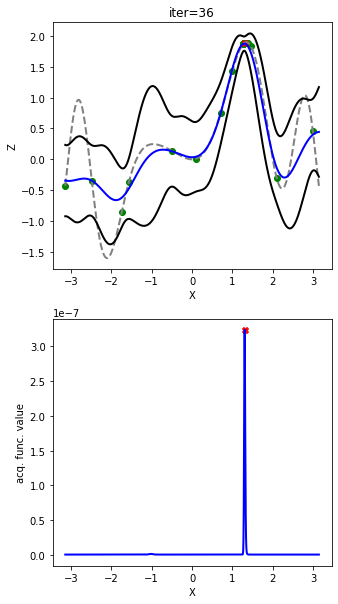

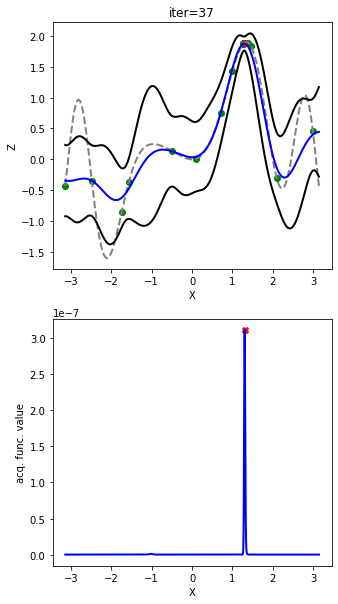

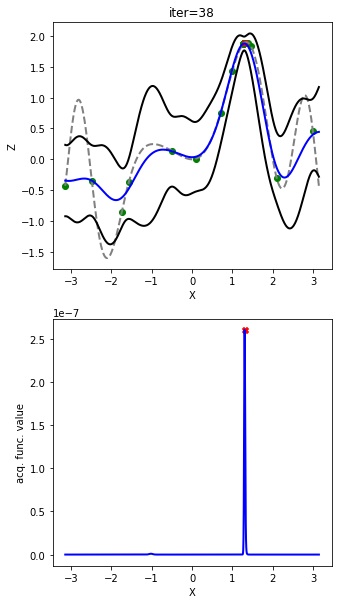

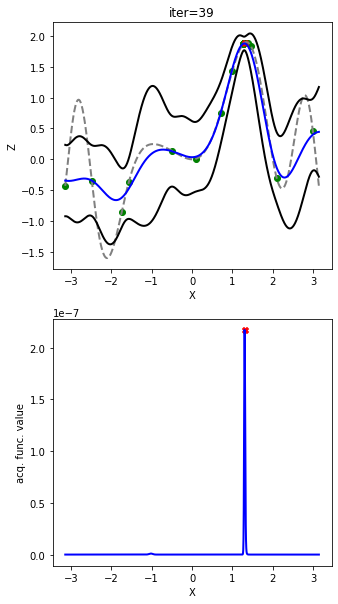

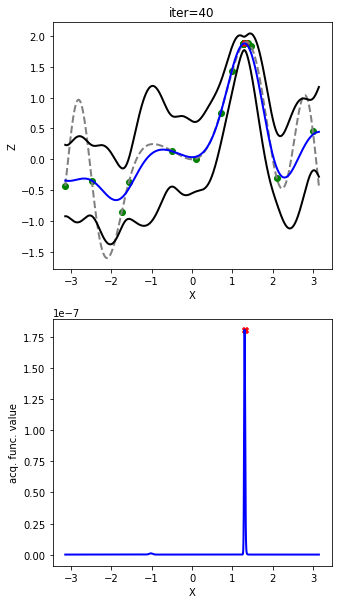

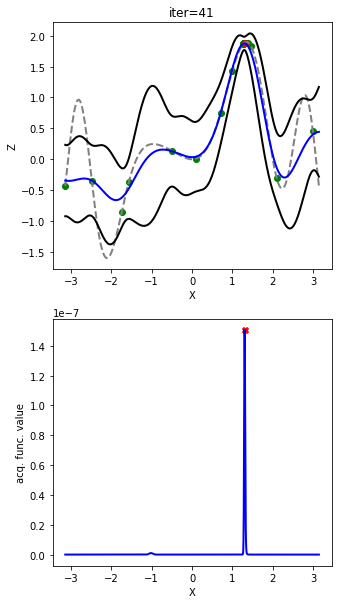

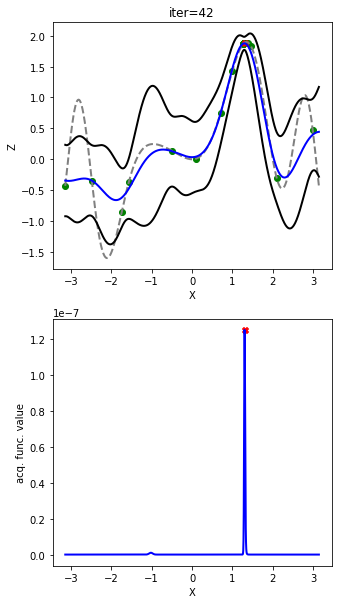

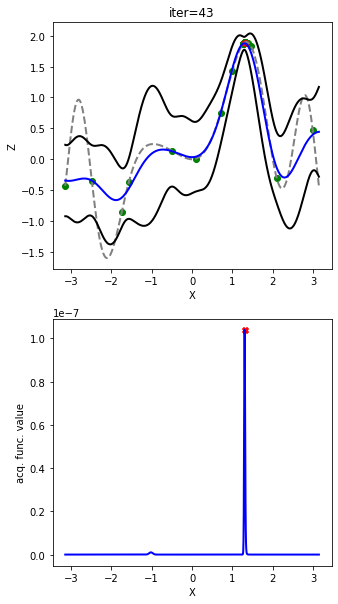

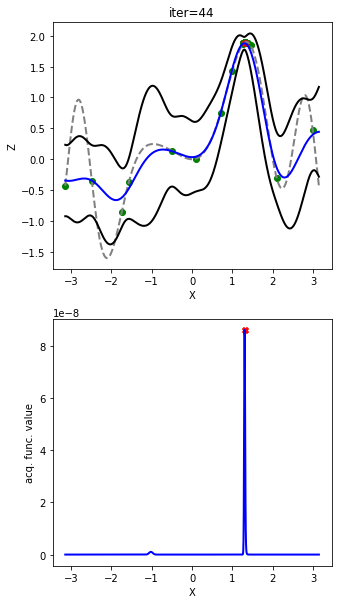

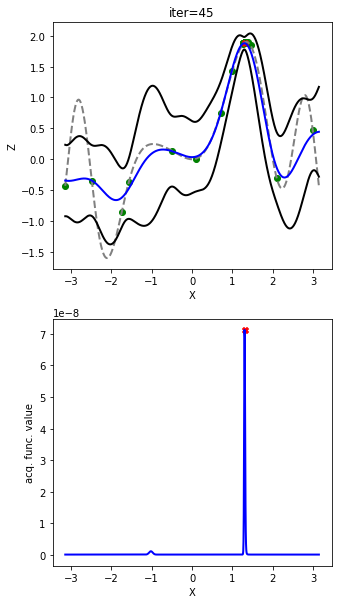

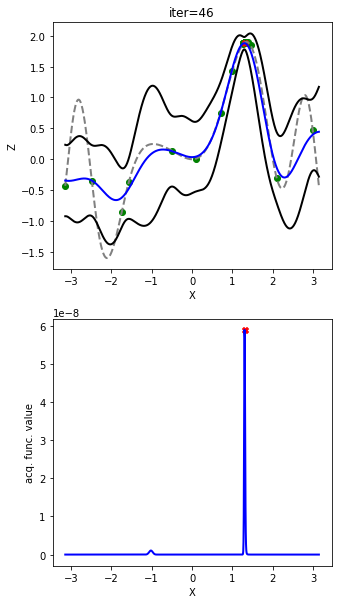

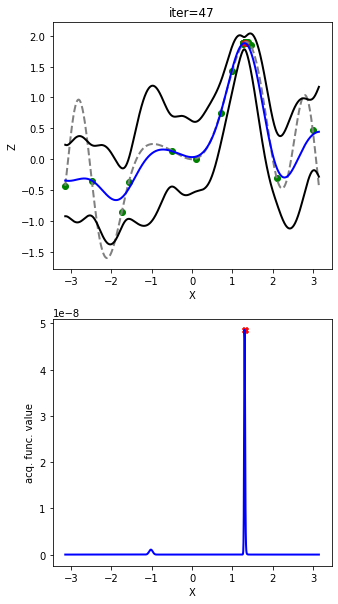

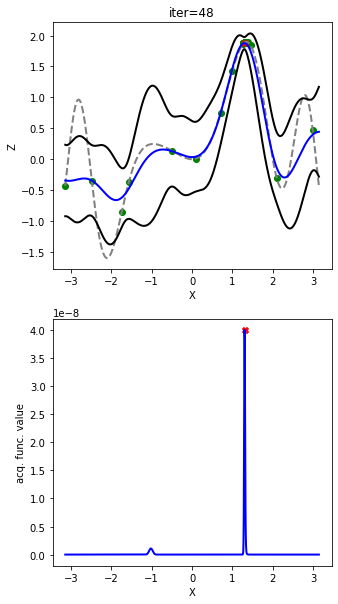

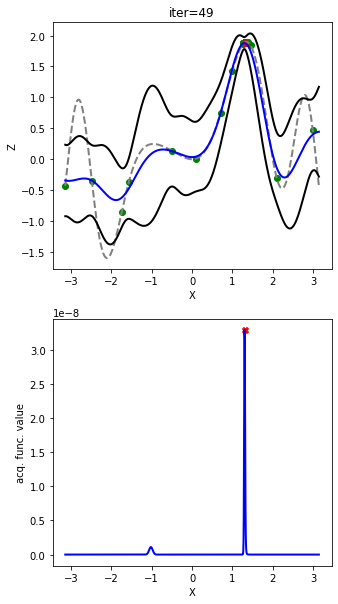

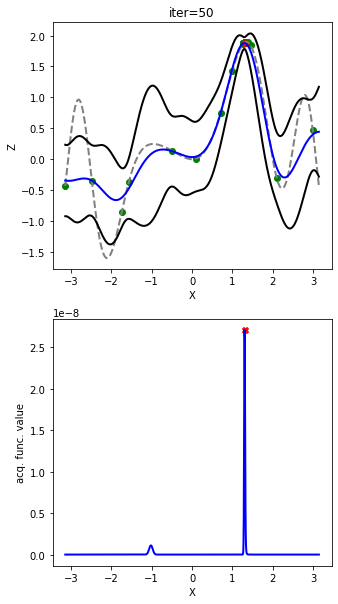

Max. sampling reached, model stopped


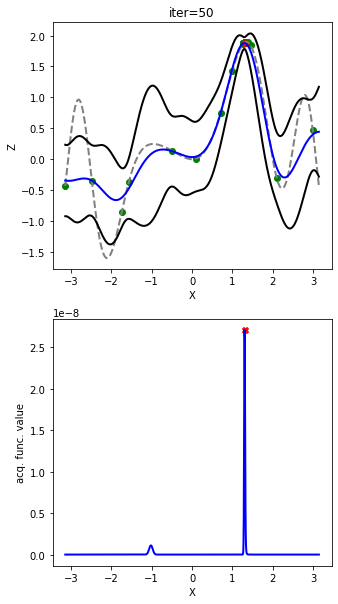

In [ ]:
############# Analysis#####################
num_rows=1000
num=5
N=50
X = np.linspace(-np.pi, np.pi, num_rows)
np.random.seed(10)
ind_start = np.random.choice(len(X) - 1, size=num, replace=False)
train_x = np.zeros(num)
train_y = np.zeros(num)
true_y = np.zeros(num_rows)
for i in range(0, num):
    train_x[i] = X[ind_start[i]]
    train_y[i] = func1D(train_x[i])

for i in range(0, num_rows):
    true_y[i] = func1D(X[i])
#Convert to torch
train_x = to.from_numpy(train_x)
train_X = to.empty(train_x.__len__(), 1)
train_X[:, 0] = train_x
train_X = train_X.double()
train_y = to.from_numpy(train_y)
train_Y = to.empty(train_y.__len__(), 1)
train_Y[:, 0] = train_y

## Gp model fit
#Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
# Input args- Torch arrays of training data, parameter X and objective eval Y
# Output args- Gaussian process model
gp_surro= optimize_hyperparam_trainGP(train_X, train_Y)


for i in range(1, N + 1):
    y_pred_means = to.empty(num_rows)
    y_pred_vars = to.empty(num_rows)
    for j in range(0, num_rows):
        test_X = to.empty(1,1)
        test_X[:, 0] = X[j]
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
             #Calculate posterior means and variances
            y_pred_surro = gp_surro.posterior(test_X)
            y_pred_means[j] = y_pred_surro.mean
            y_pred_vars[j] = y_pred_surro.variance

    ###Calling function to compute acquistion function value. Here user can select either EI-- acqmanEI() or PI--acqmanPI()
    # Input args- Torch arrays of GP posterior means, variances and current training objective eval Y
    # Output args- location cadidate for maximum acq. value, maximum acq.val. and acq. value for all candidate locations
    acq_cand, maxacq_val, acq_val = acqmanPI(y_pred_means, y_pred_vars, train_Y)
    val = maxacq_val
    ind = np.random.choice(acq_cand)
    if ((val) == 0):  # Stop for negligible expected improvement
        print("Model converged due to sufficient learning over search space ")
        break
    else:
        #Augment new data with current (training) data
        nextX = to.empty(1, 1)
        next_feval = to.empty(1, 1)
        nextX[0, 0] = X[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        next_feval[:, 0] = func1D(X[ind])
        train_Y = to.cat((train_Y, next_feval), 0)
        #plotting function
        plot_exploration_results(X, true_y, y_pred_means, y_pred_vars, train_X, train_Y, acq_val, maxacq_val, i)

        # Gp model fit
        #Updating GP with augmented training data
        #Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
        # Input args- Torch arrays of training data, parameter X and objective eval Y
        # Output args- Gaussian process model
        gp_surro = optimize_hyperparam_trainGP(train_X, train_Y)


## Final posterior prediction after all the sampling done

if (i == N):
    print("Max. sampling reached, model stopped")
    #plotting function
    plot_exploration_results(X, true_y, y_pred_means, y_pred_vars, train_X, train_Y, acq_val, maxacq_val, i)

**For the GP images--**

Gray dotted lines are the true function value, blue solid lines are the GP predicted mean, black solid lines are the GP mean ± 2x standard dev. Green dots are the current evaluated locations. Red dots are the new locations for next evaluations.

**For the acquistion function images--**

Blue solid lines are acquisition function. Red dots are the new locations (at max. acq. func. value) for next evaluations

**Lets move to part 2 notebook and extend BO to classical Multi-objective Bayesian optimization (MOBO) implementation**